In [1]:
import time
import os
import cv2
import pandas as pd

import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

In [2]:
# Load data, for any Google Drive for desktop
data_dir = "G:/.shortcut-targets-by-id/"
dir_name = 'Choosing trajectories'
filename = 'raw_velocity_data_JJ.csv'
depth_limit = 4

# just finding the dir
for subdir, dirs, files in os.walk(data_dir):
    depth = subdir.count('/') + subdir.count('\\')
    if depth > depth_limit:  # don't care about any deeper dir
        continue
    if 'Choosing trajectories' in subdir:
        dir_name = subdir
        filename = subdir + '/' + filename
        break

In [3]:
synapse_count_map = {}
'''# group each population (direct stim, monosynaptic, disynaptic)
synapse_count_map = {
    '10_02_2020 02_01_05 Inter 2_3': {
        0: [i for i in range(8)],
        1: [i for i in range(8, 12)],
        2: [12, 13]
    },
    '10_02_2020 02_01_05 Intra 2_3 removed': {
        0: [i for i in range(8)],
        1: [i for i in range(8, 12)],
        2: [12, 13]
    },
    '10_27_2020 03_01_06 Intra 4': {
        0: [i for i in range(15)],
        1: [],
        2: []
    },
    '10_29_2020 04_01_01 Inter_L5 4': {
        0: [i for i in range(5)] + [8, 9],
        1: [5,6,7,10,11],
        2: []
    },
    '12_13_2020 02_01_02 Intra 4': {
        0: [],
        1: [i for i in range(24)],
        2: []
    },
    '12_28_2020 03_01_08 Intra 2_3': {
        0: [],
        1: [2, 6, 7, 10, 11, 12, 14],
        2: [0, 1, 3, 4, 5, 8, 9, 13]
    },
    '12_29_2020 04_01_01 Inter_L23 4' : {
        0: [],
        1: [i for i in range(14)],
        2: []
    },
    '01_11_2021 09_01_01 Inter 2_3': {
        0: [],
        1: [i for i in range(9)] + [i for i in range(10, 14)],
        2: []
    },
    '01_18_2021 04_01_02 Inter 2_3': {
        0: [],
        1: [i for i in range(22)] + [23, 24, 26],
        2: []
    },
    '01_19_2021 05_01_01 Inter 2_3': {
        0: [],
        1: [i for i in range(15)] + [16, 17, 19, 20, 21],
        2: []
    },
    '03_02_2021 03_01_02 Inter 5': {
        0: [21],
        1: [i for i in range(24)],
        2: []
    },
    '03_09_2021 03_01_02 Inter 5': {
        0: [],
        1: [i for i in range(22)],
        2: []
    },
    '03_23_2021 05_01_02 Intra 5': {
        0: [],
        1: [i for i in range(12)] + [13],
        2: []
    },
    '03_23_2021 05_01_02 Inter 5': {
        0: [],
        1: [i for i in range(12)] + [13],
        2: []
    },
    '04_13_2021 03_01_02 Inter 5': {
        0: [],
        1: [i for i in range(16)],
        2: []
    },
    '05_25_2021 01_01_04 Intra 2_3': {
        0: [],
        1: [i for i in range(18)],
        2: []
    },
    '05_26_2021 02_01_04 Inter 2_3': {
        0: [],
        1: [i for i in range(18)],
        2: []
    },
    '05_31_2021 05_01_04 Inter 5': {
        0: [],
        1: [i for i in range(28)],
        2: []
    },
    '06_28_2021 03_01_02 Inter 5': {
        0: [],
        1: [i for i in range(27)],
        2: []
    },
    '06_29_2021 02_01_02 Inter 5': {
        0: [22],
        1: [i for i in range(24)],
        2: []
    },
    '08_06_2021 02_01_02 Inter_L5 4': {
        0: [],
        1: [i for i in range(18)] + [20, 21, 22],
        2: []
    },
    '08_09_2021 05_01_06 Inter_L5 4': {
        0: [],
        1: [i for i in range(22)],
        2: []
    },
    '08_31_2021 03_01_02 Inter 2_3': {
        0: [],
        1: [i for i in range(20)] + [21],
        2: []
    },
    '09_06_2021 02_01_06 Inter 2_3': {
        0: [],
        1: [i for i in range(12)] + [14, 15],
        2: [12, 13] + [i for i in range(16,22)]
    }
}'''

"# group each population (direct stim, monosynaptic, disynaptic)\nsynapse_count_map = {\n    '10_02_2020 02_01_05 Inter 2_3': {\n        0: [i for i in range(8)],\n        1: [i for i in range(8, 12)],\n        2: [12, 13]\n    },\n    '10_02_2020 02_01_05 Intra 2_3 removed': {\n        0: [i for i in range(8)],\n        1: [i for i in range(8, 12)],\n        2: [12, 13]\n    },\n    '10_27_2020 03_01_06 Intra 4': {\n        0: [i for i in range(15)],\n        1: [],\n        2: []\n    },\n    '10_29_2020 04_01_01 Inter_L5 4': {\n        0: [i for i in range(5)] + [8, 9],\n        1: [5,6,7,10,11],\n        2: []\n    },\n    '12_13_2020 02_01_02 Intra 4': {\n        0: [],\n        1: [i for i in range(24)],\n        2: []\n    },\n    '12_28_2020 03_01_08 Intra 2_3': {\n        0: [],\n        1: [2, 6, 7, 10, 11, 12, 14],\n        2: [0, 1, 3, 4, 5, 8, 9, 13]\n    },\n    '12_29_2020 04_01_01 Inter_L23 4' : {\n        0: [],\n        1: [i for i in range(14)],\n        2: []\n    }

In [4]:
# Fill in more of synapse_count_map from file
filename_combined = dir_name + '/raw_velocity_data_JJ_KS_compare.csv'
df_combined = pd.read_csv(filename_combined)
df_combined = pd.DataFrame(df_combined, columns=['Date', 'Slice_Loc_Run',
                              'Stim_Layer', 'Laminar', 'ROI_Id', 'Synaptic', 'Kate\'s Synaptic',
                               'Latency_Mono_Raw', 'Kate\'s Mono Latency', 'Distance'])
print(df_combined)
for date in df_combined.Date.unique():
    cv_subset_date = df_combined[(df_combined['Date'] == date)]
    for rec_id in cv_subset_date.Slice_Loc_Run.unique():
        cv_subset_rec_id = cv_subset_date[(cv_subset_date['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset_rec_id.Laminar.unique():
            cv_subset_lam = cv_subset_rec_id[(cv_subset_rec_id['Laminar'] == laminar_val)]
            for layer_val in cv_subset_lam.Stim_Layer.unique():
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                cv_subset = cv_subset_lam[(cv_subset_lam['Stim_Layer'] == layer_val)]
                if plot_key not in synapse_count_map:
                    synapse_count_map[plot_key] = {0: [], 1: [], 2:[]}
                    for idx, row in cv_subset.iterrows():
                        roi_id_0 = int(row['ROI_Id']) - 1
                        if type(row['Synaptic']) == str:
                            
                            if "Mono" in row['Synaptic']:
                                print(roi_id_0, 1)
                                synapse_count_map[plot_key][1].append(roi_id_0)
                            elif "Disyn" in row['Synaptic']:
                                print(roi_id_0, 2)
                                synapse_count_map[plot_key][2].append(roi_id_0)
                            elif "Dir" in row['Synaptic']:
                                print(roi_id_0, 0)
                                synapse_count_map[plot_key][0].append(roi_id_0)
                

            Date Slice_Loc_Run Stim_Layer Laminar  ROI_Id            Synaptic  \
0     10_02_2020      02_01_05        2_3   Inter       1  Direct Stimulation   
1     10_02_2020      02_01_05        2_3   Inter       2  Direct Stimulation   
2     10_02_2020      02_01_05        2_3   Inter       3  Direct Stimulation   
3     10_02_2020      02_01_05        2_3   Inter       4  Direct Stimulation   
4     10_02_2020      02_01_05        2_3   Inter       5  Direct Stimulation   
...          ...           ...        ...     ...     ...                 ...   
1782  09_06_2021      08_01_04        2_3   Intra      10             No_resp   
1783  09_06_2021      08_01_04        2_3   Intra      11          Disynaptic   
1784  09_06_2021      08_01_04        2_3   Intra      12          Disynaptic   
1785  09_06_2021      08_01_04        2_3   Intra      13          Disynaptic   
1786  09_06_2021      08_01_04        2_3   Intra      14          Disynaptic   

     Kate's Synaptic  Laten

#  10_02_2020 02_01_05 Inter 2_3
0-synapse Velocity: 233.22 um / ms
1-synapse Velocity: 117.63 um / ms
2-synapse Velocity: 52.41 um / ms
Num points: 14


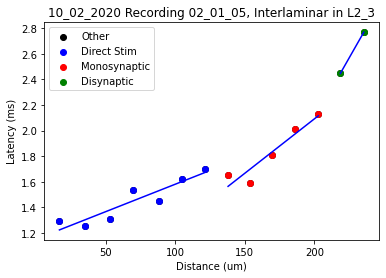

#  10_02_2020 02_01_05 Intra 2_3
0-synapse Velocity: 181.75 um / ms
1-synapse Velocity: 221.63 um / ms
2-synapse Velocity: 33.91 um / ms
Num points: 23


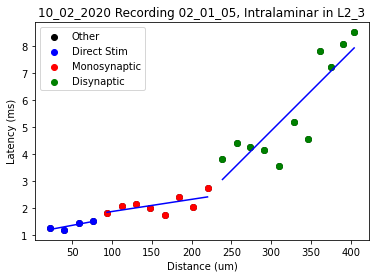

#  10_27_2020 03_01_06 Intra 4
1-synapse Velocity: -203.26 um / ms
2-synapse Velocity: 219.2 um / ms
Num points: 15


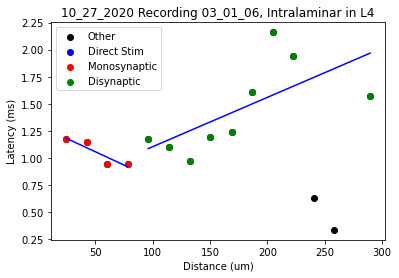

#  12_13_2020 02_01_02 Intra 4
1-synapse Velocity: 285.71 um / ms
2-synapse Velocity: -1588.16 um / ms
Num points: 25


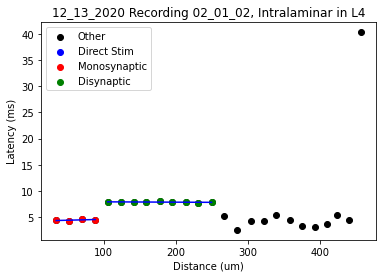

#  12_28_2020 03_01_08 Intra 2_3
1-synapse Velocity: 120.94 um / ms
Num points: 15


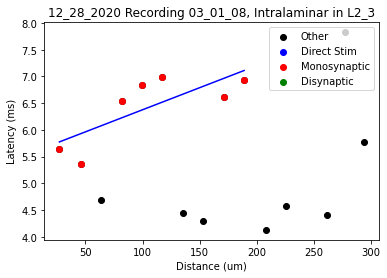

#  12_28_2020 04_01_01 Inter_L5 4
0-synapse Velocity: -186.32 um / ms
1-synapse Velocity: 53.67 um / ms
Num points: 11


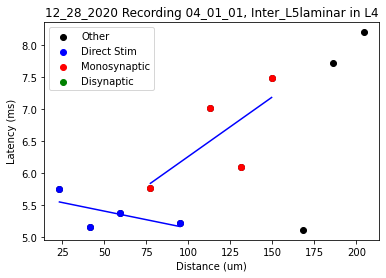

#  12_28_2020 06_01_01 Inter_L23 4
1-synapse Velocity: 265.66 um / ms
Num points: 12


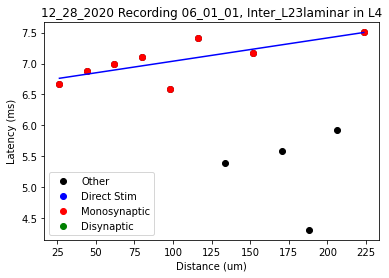

#  12_28_2020 08_01_04 Inter_L23 4
1-synapse Velocity: 123.11 um / ms
2-synapse Velocity: 368.22 um / ms
Num points: 18


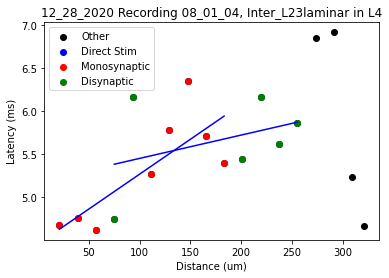

#  12_28_2020 10_01_01 Inter_L23 4
2-synapse Velocity: -395.47 um / ms
Num points: 12


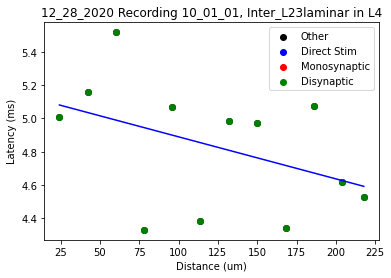

#  12_28_2020 11_01_06 Inter_L23 4
0-synapse Velocity: -183.59 um / ms
2-synapse Velocity: -128.49 um / ms
Num points: 16


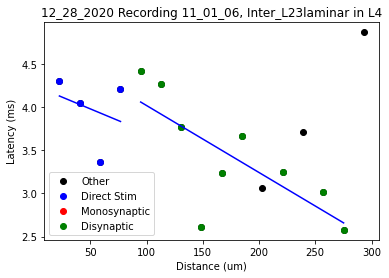

#  12_29_2020 04_01_01 Inter_L23 4
0-synapse Velocity: -7444.61 um / ms
1-synapse Velocity: 256.59 um / ms
Num points: 16


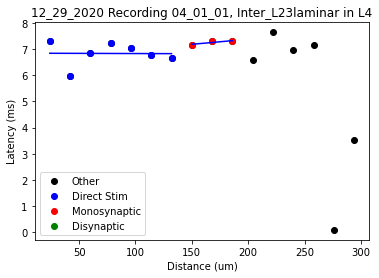

#  12_29_2020 06_01_01 Inter_L23 4
1-synapse Velocity: 166.52 um / ms
Num points: 17


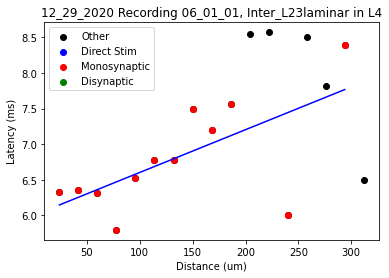

#  12_29_2020 07_01_03 Intra 4
0-synapse Velocity: 120.57 um / ms
1-synapse Velocity: 134.87 um / ms
Num points: 18


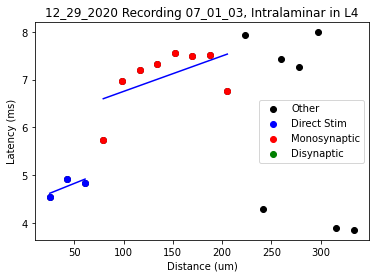

#  12_29_2020 09_01_02 Inter_L23 4
1-synapse Velocity: 193.22 um / ms
Num points: 11


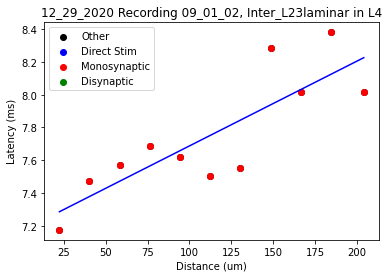

#  01_11_2021 09_01_01 Inter 2_3
1-synapse Velocity: 277.66 um / ms
Num points: 14


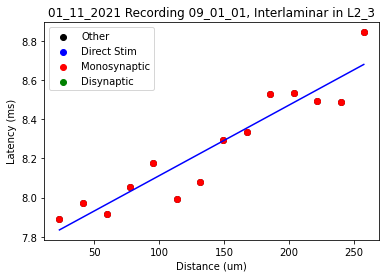

#  01_18_2021 04_01_02 Inter 2_3
0-synapse Velocity: -595.57 um / ms
1-synapse Velocity: -128.52 um / ms
2-synapse Velocity: -946.71 um / ms
Num points: 27


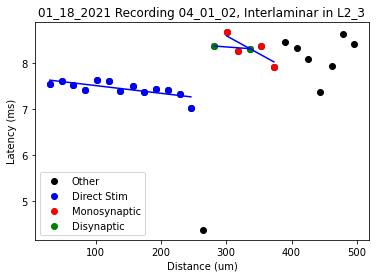

#  01_18_2021 05_01_03 Inter 2_3
2-synapse Velocity: 336.28 um / ms
Num points: 16


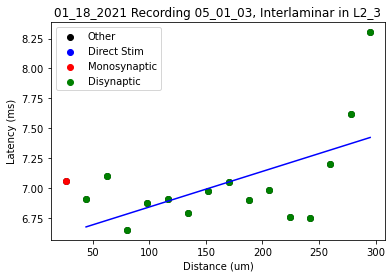

#  01_18_2021 07_01_02 Inter 2_3
1-synapse Velocity: -2012.01 um / ms
Num points: 20


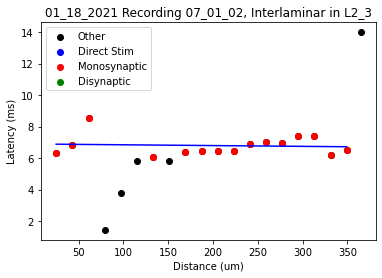

#  01_19_2021 05_01_01 Inter 2_3
1-synapse Velocity: 394.6 um / ms
Num points: 22


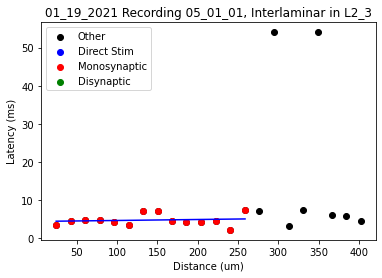

#  03_02_2021 03_01_02 Inter 5
1-synapse Velocity: 499.24 um / ms
Num points: 24


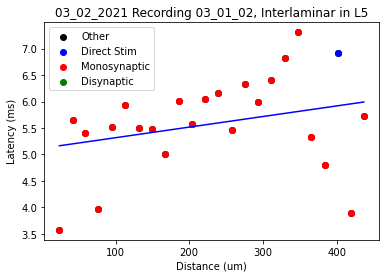

#  03_02_2021 05_01_02 Inter 5
1-synapse Velocity: 144.02 um / ms
Num points: 24


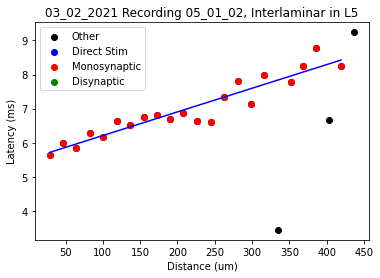

#  03_02_2021 07_01_03 Inter 5
1-synapse Velocity: 304.24 um / ms
Num points: 21


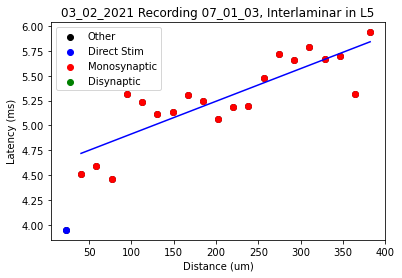

#  03_02_2021 08_01_01 Intra 5
1-synapse Velocity: 74.67 um / ms
2-synapse Velocity: 262.61 um / ms
Num points: 16


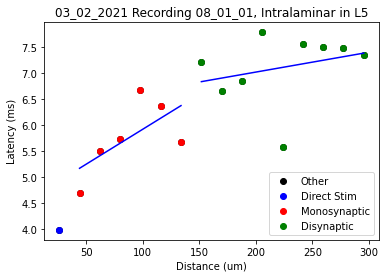

#  03_02_2021 08_01_01 Inter 5
1-synapse Velocity: 103.42 um / ms
Num points: 20


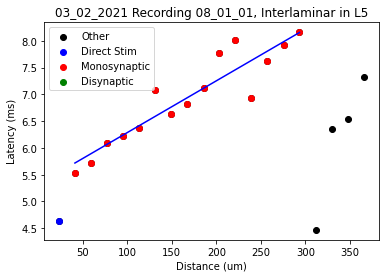

#  03_09_2021 03_01_02 Inter 5
1-synapse Velocity: 295.78 um / ms
Num points: 22


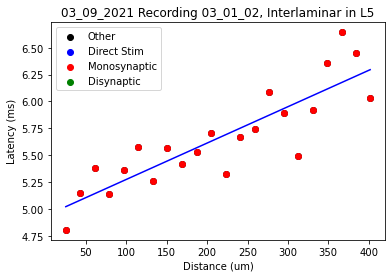

#  03_09_2021 05_01_02 Inter 5
1-synapse Velocity: 322.65 um / ms
Num points: 18


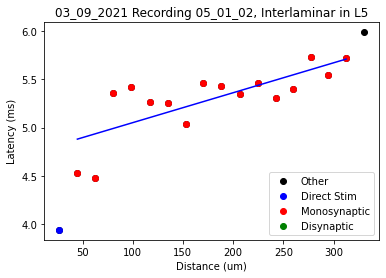

#  03_23_2021 05_01_02 Inter 5
1-synapse Velocity: 138.27 um / ms
Num points: 14


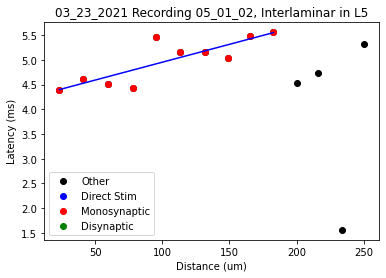

#  03_23_2021 05_01_02 Intra 5
0-synapse Velocity: 202.1 um / ms
1-synapse Velocity: -173.68 um / ms
Num points: 22


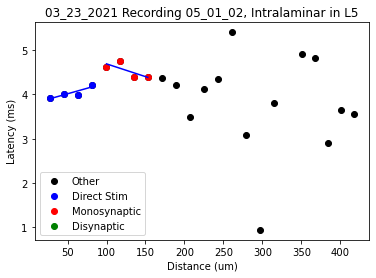

#  03_23_2021 06_01_01 Inter 5
0-synapse Velocity: 62.86 um / ms
1-synapse Velocity: -3352.88 um / ms
Num points: 17


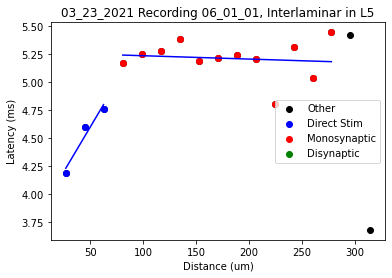

#  03_23_2021 07_01_01 Inter 5
1-synapse Velocity: 147.78 um / ms
Num points: 21


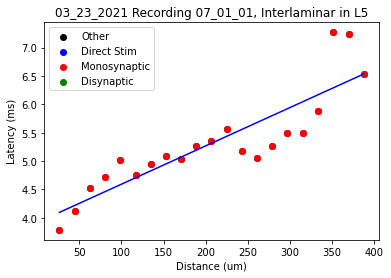

#  04_13_2021 03_01_02 Inter 5
1-synapse Velocity: 218.38 um / ms
Num points: 16


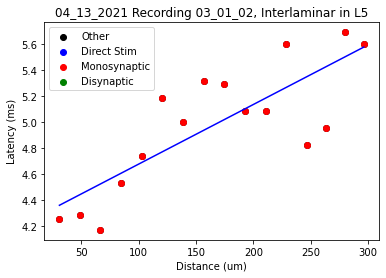

#  04_13_2021 03_01_02 Intra 5
0-synapse Velocity: -47.35 um / ms
1-synapse Velocity: 104.88 um / ms
Num points: 18


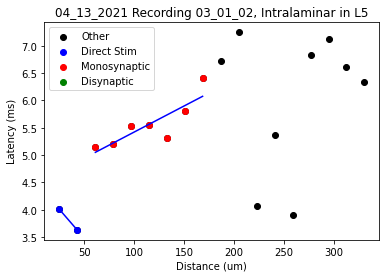

#  04_13_2021 04_01_02 Inter 2_3
1-synapse Velocity: 774.15 um / ms
Num points: 12


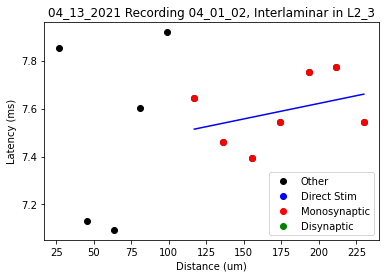

#  04_13_2021 05_01_01 Intra 2_3
1-synapse Velocity: 304.18 um / ms
Num points: 18


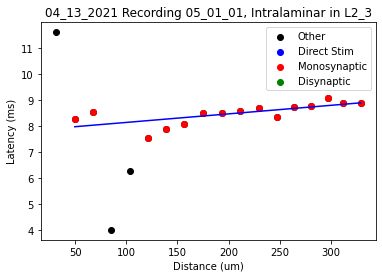

#  04_13_2021 05_01_01 Inter 2_3
1-synapse Velocity: 151.52 um / ms
Num points: 16


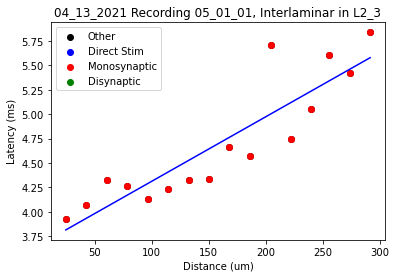

#  04_13_2021 06_01_01 Inter 2_3
0-synapse Velocity: 82.52 um / ms
1-synapse Velocity: 181.6 um / ms
Num points: 22


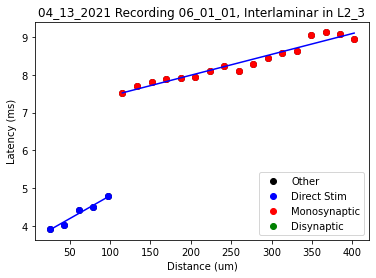

#  04_13_2021 07_01_02 Inter_L23 4
1-synapse Velocity: 92.88 um / ms
Num points: 21


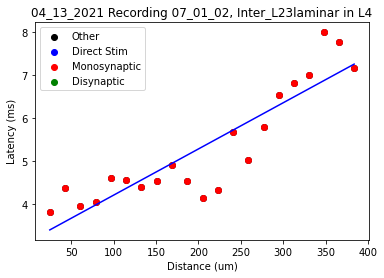

#  04_13_2021 07_01_02 Intra 4
0-synapse Velocity: 3250.91 um / ms
1-synapse Velocity: 233.34 um / ms
Num points: 15


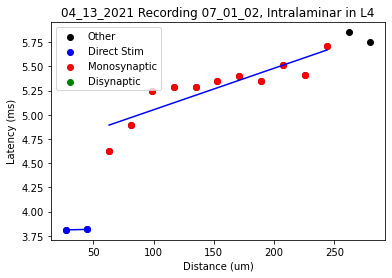

#  04_13_2021 08_01_01 Inter 2_3
0-synapse Velocity: -96.01 um / ms
1-synapse Velocity: 240.3 um / ms
Num points: 12


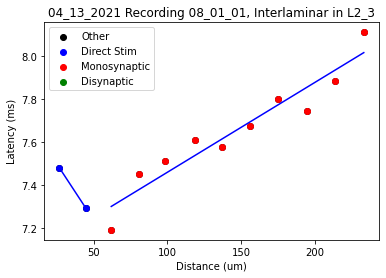

#  05_25_2021 01_01_04 Intra 2_3
1-synapse Velocity: 442.19 um / ms
Num points: 18


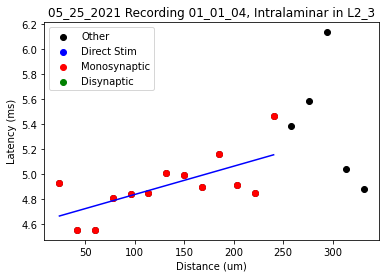

#  05_25_2021 02_01_03 Inter 2_3
1-synapse Velocity: 251.73 um / ms
2-synapse Velocity: 74.96 um / ms
Num points: 21


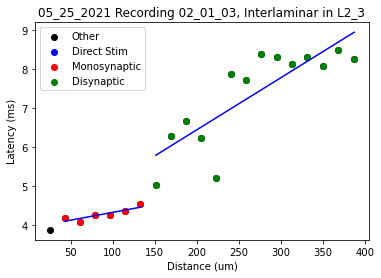

#  05_25_2021 02_01_03 Intra 2_3
1-synapse Velocity: 110.65 um / ms
2-synapse Velocity: 32.89 um / ms
Num points: 13


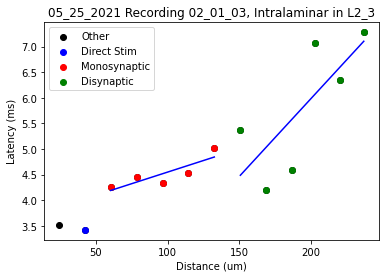

#  05_25_2021 03_01_05 Inter 2_3
1-synapse Velocity: 1462.86 um / ms
2-synapse Velocity: -197.86 um / ms
Num points: 21


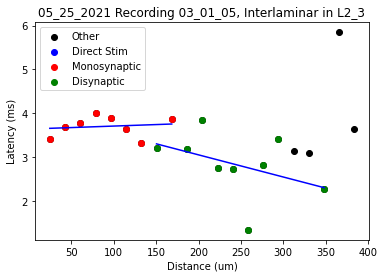

#  05_25_2021 04_01_03 Inter 2_3
0-synapse Velocity: 61.77 um / ms
1-synapse Velocity: 195.24 um / ms
Num points: 15


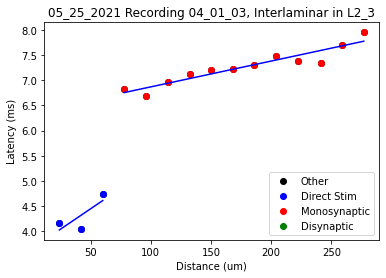

#  05_25_2021 05_01_04 Inter 2_3
1-synapse Velocity: 460.5 um / ms
Num points: 12


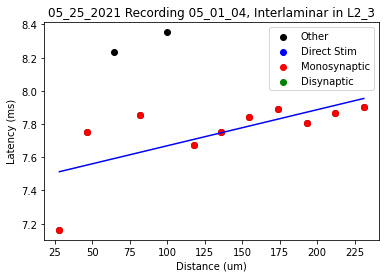

#  05_25_2021 07_01_03 Intra 4
0-synapse Velocity: 192.8 um / ms
1-synapse Velocity: 90.13 um / ms
Num points: 15


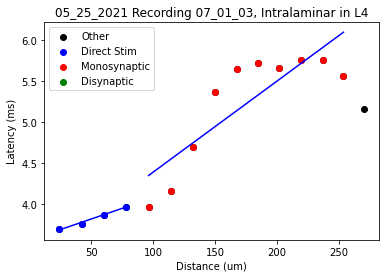

#  05_25_2021 08_01_04 Inter_L23 4
1-synapse Velocity: 257.43 um / ms
2-synapse Velocity: -66.85 um / ms
Num points: 23


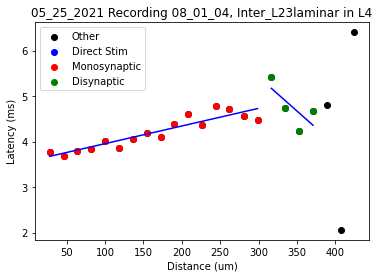

#  05_25_2021 08_01_04 Intra 4
1-synapse Velocity: 181.68 um / ms
Num points: 12


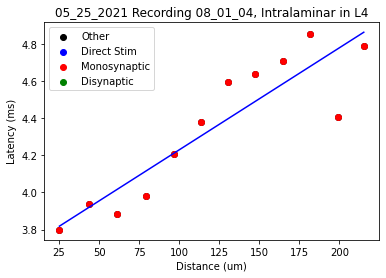

#  05_25_2021 09_01_04 Inter 2_3
1-synapse Velocity: 172.2 um / ms
2-synapse Velocity: 179.58 um / ms
Num points: 16


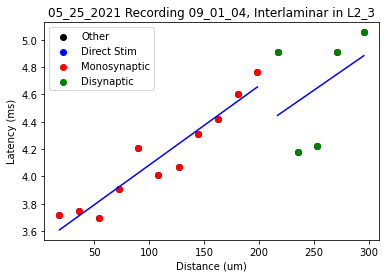

#  05_25_2021 09_01_04 Intra 2_3
1-synapse Velocity: 116.8 um / ms
Num points: 18


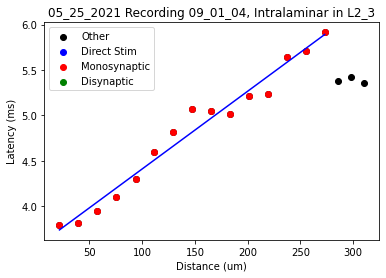

#  05_26_2021 02_01_04 Inter 2_3
0-synapse Velocity: 176.23 um / ms
1-synapse Velocity: 163.48 um / ms
Num points: 18


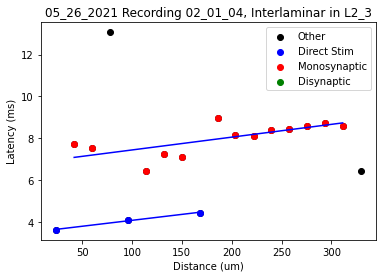

#  05_26_2021 04_01_05 Inter 2_3
1-synapse Velocity: 236.29 um / ms
Num points: 17


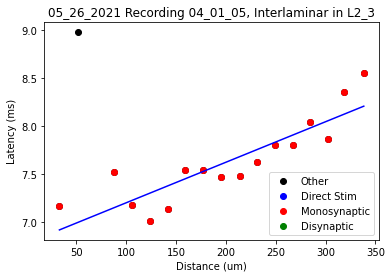

#  05_26_2021 04_01_05 Intra 2_3
1-synapse Velocity: 112.5 um / ms
2-synapse Velocity: 84.59 um / ms
Num points: 14


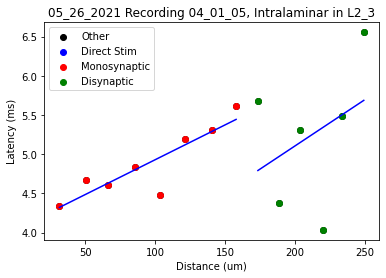

#  05_26_2021 05_01_03 Inter 2_3
1-synapse Velocity: 460.67 um / ms
Num points: 18


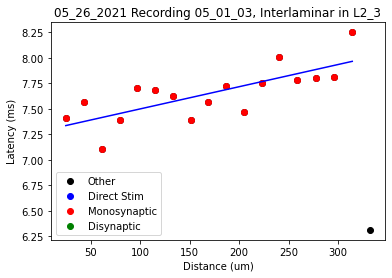

#  05_26_2021 05_01_03 Intra 2_3
1-synapse Velocity: 236.08 um / ms
Num points: 14


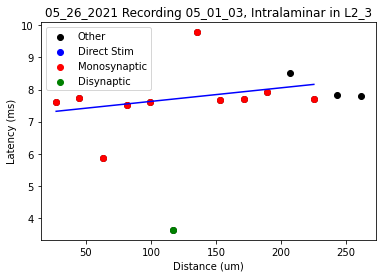

#  05_26_2021 07_01_03 Inter_L5 4
0-synapse Velocity: 74.97 um / ms
1-synapse Velocity: 117.84 um / ms
Num points: 17


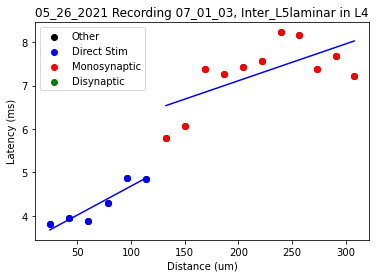

#  05_26_2021 07_01_03 Intra 4
0-synapse Velocity: -387.35 um / ms
1-synapse Velocity: 94.37 um / ms
Num points: 22


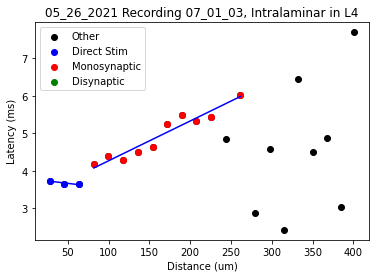

#  05_31_2021 05_01_04 Inter 5
0-synapse Velocity: -405.06 um / ms
1-synapse Velocity: 450.52 um / ms
2-synapse Velocity: -209.04 um / ms
Num points: 28


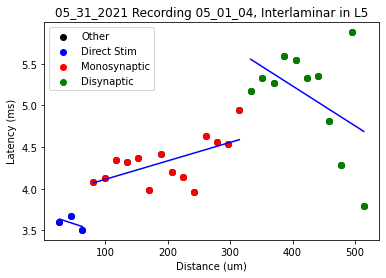

#  05_31_2021 06_01_05 Inter 2_3
1-synapse Velocity: 514.96 um / ms
2-synapse Velocity: 3228.09 um / ms
Num points: 20


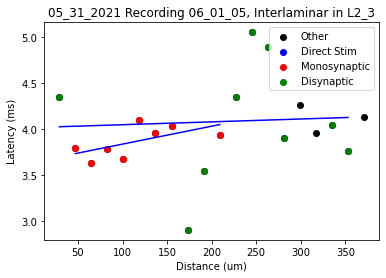

#  05_31_2021 06_01_05 Intra 2_3
1-synapse Velocity: 670.5 um / ms
2-synapse Velocity: -120.26 um / ms
Num points: 16


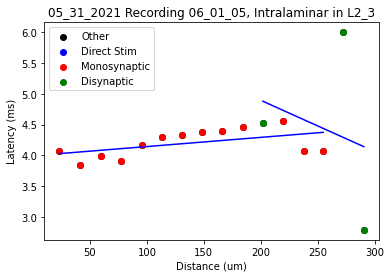

#  05_31_2021 07_01_05 Inter 2_3
0-synapse Velocity: 873.5 um / ms
1-synapse Velocity: 377.83 um / ms
Num points: 19


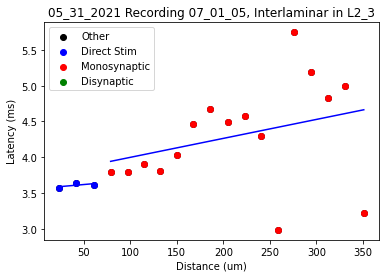

#  05_31_2021 07_01_05 Intra 2_3
0-synapse Velocity: -365.81 um / ms
1-synapse Velocity: 498.55 um / ms
2-synapse Velocity: -52.48 um / ms
Num points: 18


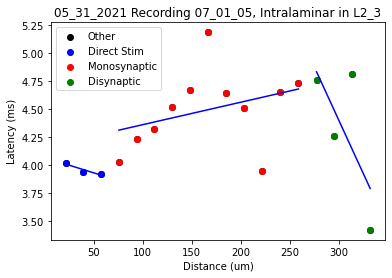

#  05_31_2021 09_01_05 Inter 2_3
1-synapse Velocity: 1136.04 um / ms
2-synapse Velocity: 13.48 um / ms
Num points: 19


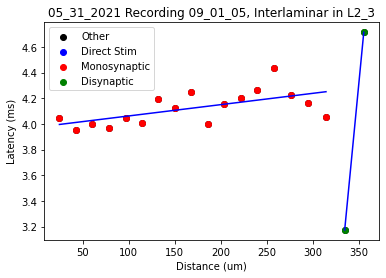

#  05_31_2021 10_01_05 Inter 2_3
1-synapse Velocity: 157.5 um / ms
2-synapse Velocity: -235.19 um / ms
Num points: 21


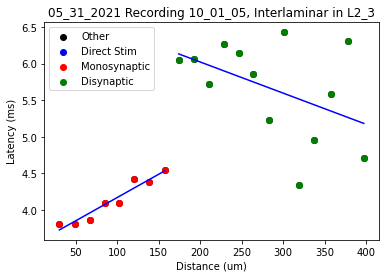

#  06_28_2021 03_01_02 Inter 5
1-synapse Velocity: 241.18 um / ms
Num points: 27


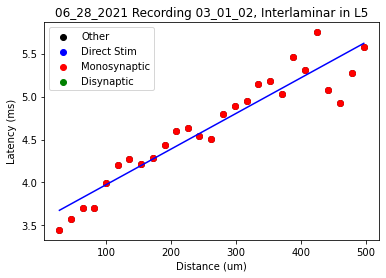

#  06_28_2021 04_01_02 Inter 5
0-synapse Velocity: -376.42 um / ms
1-synapse Velocity: 257.87 um / ms
Num points: 27


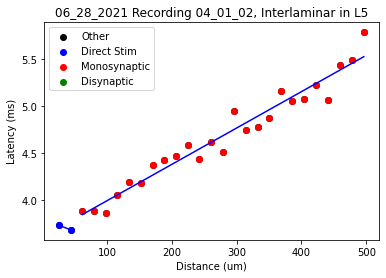

#  06_28_2021 05_01_02 Inter 5
0-synapse Velocity: 309.28 um / ms
1-synapse Velocity: 401.8 um / ms
Num points: 24


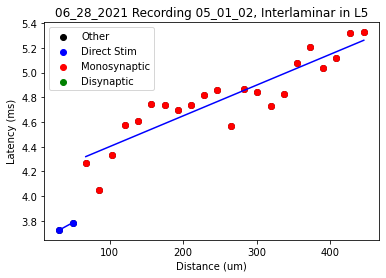

#  06_28_2021 06_01_01 Inter 5
0-synapse Velocity: 906.25 um / ms
1-synapse Velocity: 237.16 um / ms
Num points: 27


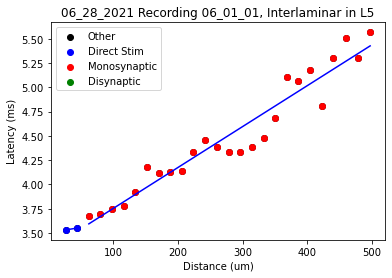

#  06_29_2021 02_01_02 Inter 5
1-synapse Velocity: 221.61 um / ms
Num points: 24


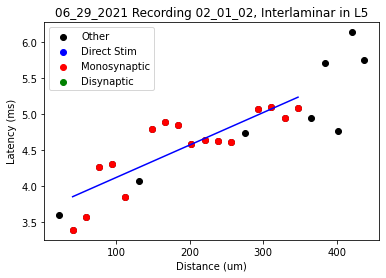

#  06_29_2021 02_01_02 Intra 5
1-synapse Velocity: 135.77 um / ms
Num points: 15


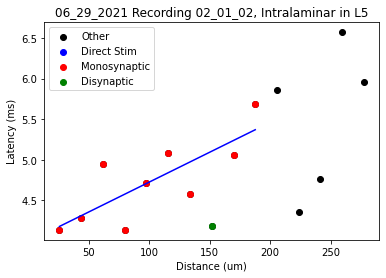

#  06_29_2021 04_01_02 Inter 5
1-synapse Velocity: 213.39 um / ms
Num points: 21


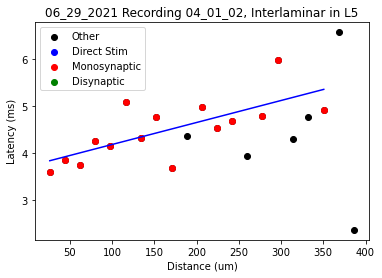

#  06_29_2021 04_01_02 Intra 5
0-synapse Velocity: 397.37 um / ms
1-synapse Velocity: 141.98 um / ms
Num points: 18


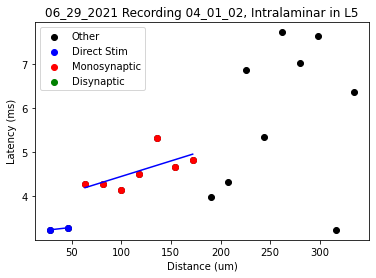

#  06_29_2021 05_01_01 Inter 5
1-synapse Velocity: 288.73 um / ms
Num points: 21


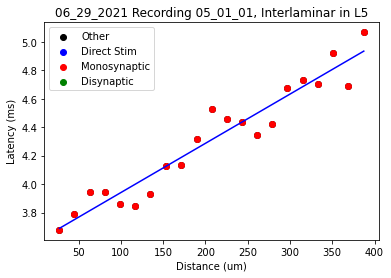

#  06_29_2021 05_01_01 Intra 5
1-synapse Velocity: 98.45 um / ms
Num points: 15


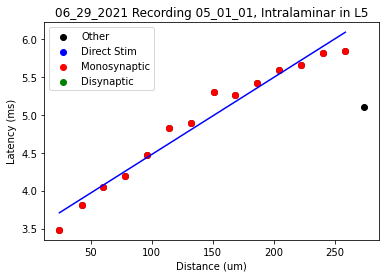

#  06_29_2021 07_01_02 Inter 5
1-synapse Velocity: 381.46 um / ms
Num points: 23


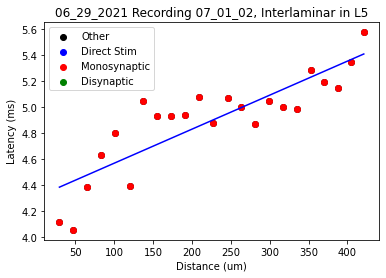

#  08_06_2021 02_01_02 Inter_L5 4
1-synapse Velocity: 316.26 um / ms
2-synapse Velocity: -219.43 um / ms
Num points: 23


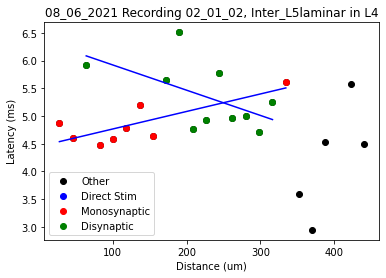

#  08_06_2021 02_01_02 Intra 4
0-synapse Velocity: -128.22 um / ms
1-synapse Velocity: 121.72 um / ms
Num points: 11


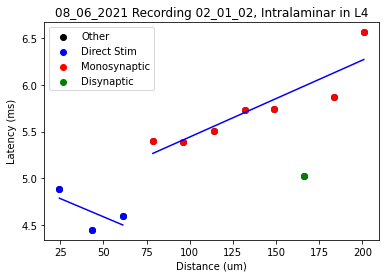

#  08_06_2021 04_01_01 Inter 2_3
1-synapse Velocity: 255.99 um / ms
2-synapse Velocity: -93.15 um / ms
Num points: 20


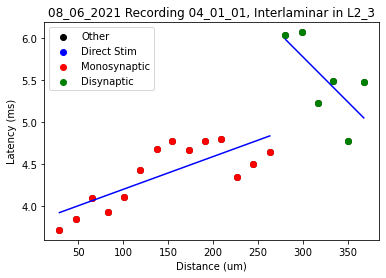

#  08_06_2021 04_01_01 Intra 2_3
1-synapse Velocity: 128.76 um / ms
2-synapse Velocity: 26.87 um / ms
Num points: 17


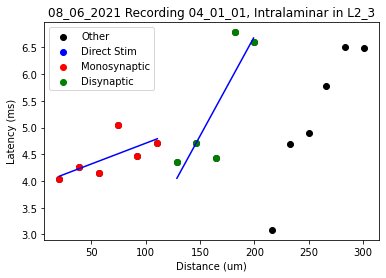

#  08_06_2021 05_01_03 Inter 2_3
1-synapse Velocity: 404.54 um / ms
2-synapse Velocity: 879.35 um / ms
Num points: 22


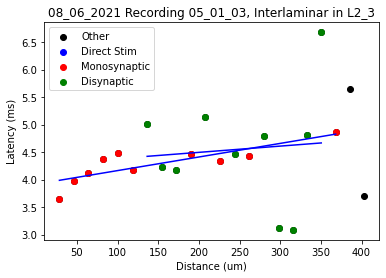

#  08_06_2021 05_01_03 Intra 2_3
1-synapse Velocity: 139.66 um / ms
2-synapse Velocity: 35.45 um / ms
Num points: 16


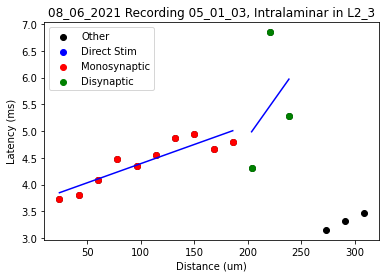

#  08_06_2021 07_01_03 Inter_L5 4
1-synapse Velocity: 284.94 um / ms
2-synapse Velocity: -184.24 um / ms
Num points: 22


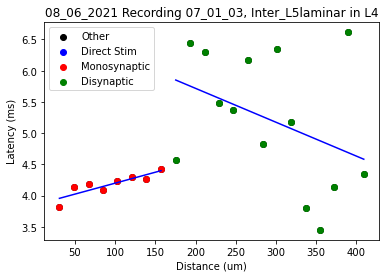

#  08_06_2021 07_01_03 Intra 4
1-synapse Velocity: 145.41 um / ms
2-synapse Velocity: 406.2 um / ms
Num points: 13


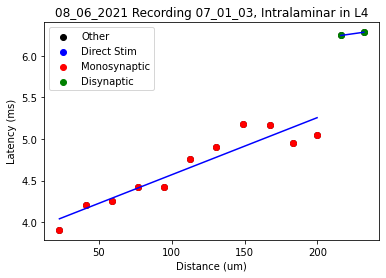

#  08_06_2021 08_01_03 Intra 2_3
1-synapse Velocity: 230.51 um / ms
2-synapse Velocity: -331.23 um / ms
Num points: 18


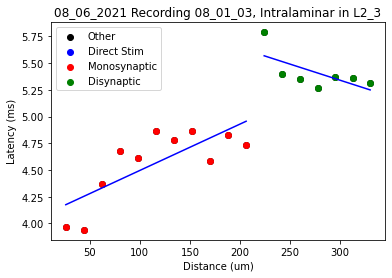

#  08_06_2021 08_01_03 Inter 2_3
1-synapse Velocity: 293.91 um / ms
2-synapse Velocity: 291.64 um / ms
Num points: 22


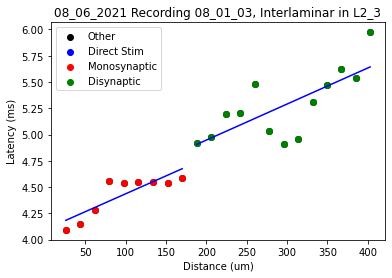

#  08_09_2021 05_01_06 Inter_L5 4
0-synapse Velocity: 1103.11 um / ms
1-synapse Velocity: 120.56 um / ms
2-synapse Velocity: 553.2 um / ms
Num points: 22


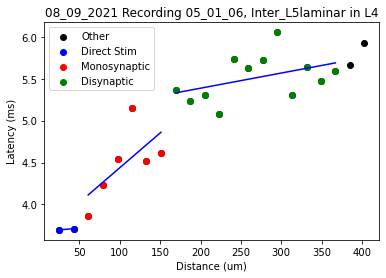

#  08_09_2021 06_01_04 Inter 2_3
1-synapse Velocity: 360.2 um / ms
2-synapse Velocity: -191.42 um / ms
Num points: 19


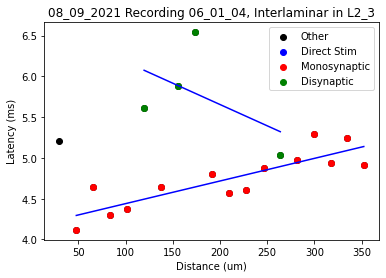

#  08_31_2021 03_01_02 Inter 2_3
1-synapse Velocity: 294.35 um / ms
2-synapse Velocity: -2941.76 um / ms
Num points: 22


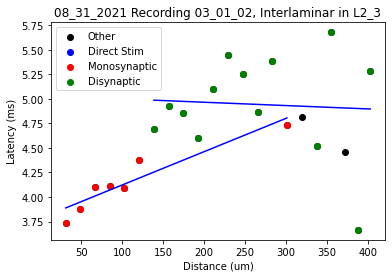

#  09_06_2021 02_01_06 Inter 2_3
1-synapse Velocity: 131.0 um / ms
2-synapse Velocity: 148.75 um / ms
Num points: 22


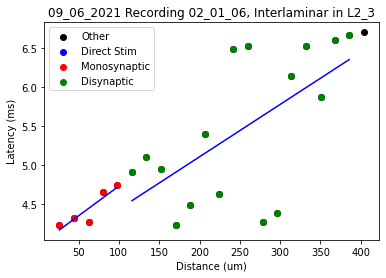

#  09_06_2021 03_01_04 Inter 2_3
1-synapse Velocity: 226.4 um / ms
2-synapse Velocity: 262.99 um / ms
Num points: 15


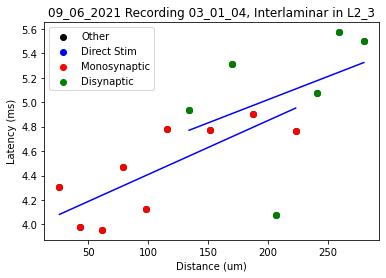

#  09_06_2021 04_01_04 Inter 2_3
1-synapse Velocity: 187.26 um / ms
2-synapse Velocity: 219.96 um / ms
Num points: 25


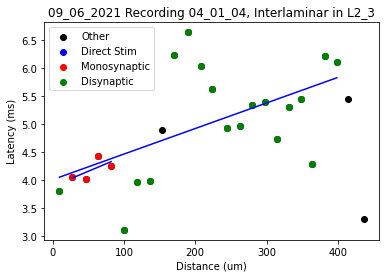

#  09_06_2021 04_01_04 Intra 2_3
1-synapse Velocity: 181.03 um / ms
2-synapse Velocity: 3.67 um / ms
Num points: 16


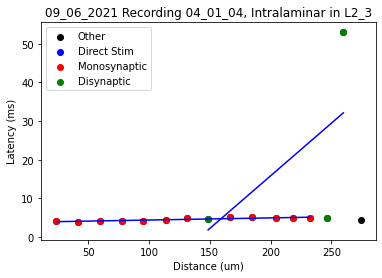

#  09_06_2021 07_01_04 Inter 2_3
1-synapse Velocity: 451.56 um / ms
2-synapse Velocity: -615.8 um / ms
Num points: 26


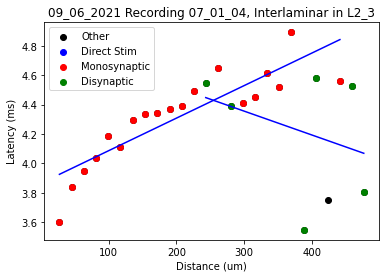

#  09_06_2021 07_01_04 Intra 2_3
1-synapse Velocity: 234.04 um / ms
Num points: 13


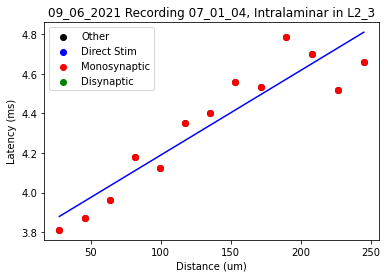

#  09_06_2021 08_01_04 Inter 2_3
1-synapse Velocity: 287.43 um / ms
2-synapse Velocity: 220.85 um / ms
Num points: 24


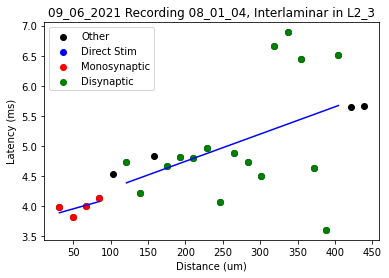

#  09_06_2021 08_01_04 Intra 2_3
1-synapse Velocity: 169.17 um / ms
2-synapse Velocity: 69.57 um / ms
Num points: 14


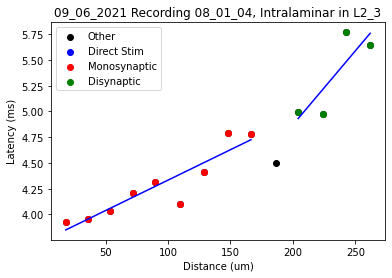

total_points: 1780
Unplotted plot keys: []


In [5]:
# load original CSV
        
df = pd.read_csv(filename)
df = pd.DataFrame(df, columns=['Date', 'Age_Days', 'Sex', 'Tx', 'Slice_Loc_Run',
                              'Trial_x_Time', 'Stim_Intensity', 'Cx', 'n_Pulses',
                              'Stim_Layer', 'Laminar', 'ROI_Id', 'SNR', 
                               'Latency_Mono_Raw', 'Distance'])

df = df_combined

df['Latency_Calc'] = df['Latency_Mono_Raw'] - 46.0  # 46 ms is stim time
df.drop(df[df['Latency_Calc'] <= 0].index, inplace=True)  # negative values are non-physical

# 6 um per pixel on new rig (see https://github.com/john-judge/TSM-to-ZDA/issues/12)
df['Distance'] *= 6.0

# targets to plot
laminar_val_target = "Inter"
layer_val_target = "5"
plot_all = True  # overrides above 2 lines
total_points = 0
unplotted_plot_keys = []

velocity_measurements = {}
colors = ['b', 'r', 'g']
# for each recording/laminar/direction measurement, plot latency vs distance
for date in df.Date.unique():
    cv_subset_date = df[(df['Date'] == date)]
    for rec_id in cv_subset_date.Slice_Loc_Run.unique():
        cv_subset_rec_id = cv_subset_date[(cv_subset_date['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset_rec_id.Laminar.unique():
            cv_subset_lam = cv_subset_rec_id[(cv_subset_rec_id['Laminar'] == laminar_val)]
            for layer_val in cv_subset_lam.Stim_Layer.unique():
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                if plot_all or (laminar_val_target == laminar_val and layer_val_target == layer_val):
                    cv_subset = cv_subset_lam[(cv_subset_lam['Stim_Layer'] == layer_val)]
                    plt.clf()
                    plt.scatter(cv_subset['Distance'], 
                                cv_subset['Latency_Calc'],
                                c='black')
                    print("# ", plot_key)
                    if plot_key in synapse_count_map:

                        # analyze and plot each synapse-count group separately
                        reg_lines = []
                        for i_synap in [0, 1, 2]:
                            ind_list = synapse_count_map[plot_key][i_synap]
                            for k in range(len(ind_list)-1, -1, -1):
                                if ind_list[k] > len(cv_subset['Distance'])-1:
                                    del ind_list[k]
                            try:
                                syn_cv_subset = cv_subset.iloc[ind_list]
                            except Exception as e:
                                print(ind_list, e)
                            dist = np.array(syn_cv_subset['Distance']).reshape(-1, 1)
                            latency = np.array(syn_cv_subset['Latency_Calc']).reshape(-1, 1)
                            plt.scatter(dist, latency, c=colors[i_synap])

                            if dist.size > 1:
                                regr = linear_model.LinearRegression()
                                regr.fit(dist, latency)
                                y_pred = regr.predict(dist)
                                velocity = round(1/ regr.coef_[0][0], 5)
                                reg_lines.append([dist, y_pred, velocity, i_synap])
                                vel_key = laminar_val + " " + layer_val
                                if vel_key not in velocity_measurements:
                                    velocity_measurements[vel_key] = {}
                                if i_synap not in velocity_measurements[vel_key]:
                                    velocity_measurements[vel_key][i_synap] = []
                                velocity_measurements[vel_key][i_synap].append(velocity)

                        plt.legend(["Other","Direct Stim", "Monosynaptic", "Disynaptic"])
                        for rl in reg_lines:
                            dist, y_pred, velocity, i_synap = rl
                            plt.plot(dist, y_pred, c='b')
                            print(str(i_synap) + "-synapse Velocity:", round(velocity, 2), "um / ms")
                    else:
                        unplotted_plot_keys.append(plot_key)

                    plt.title(date + " Recording " + rec_id + ", " + laminar_val + "laminar in L" + layer_val)
                    plt.xlabel('Distance (um)')
                    plt.ylabel('Latency (ms)')
                    total_points += len(cv_subset['Distance'])
                    print("Num points:", len(cv_subset['Distance']))
                    plt.show()
                    
print("total_points:", total_points)
print("Unplotted plot keys:", unplotted_plot_keys)

In [10]:
# plots of velocity measurements
for vel_key in velocity_measurements:
    print("# ", vel_key)
    for i_synap in velocity_measurements[vel_key]:
        print("## ", str(i_synap) + "-synapse:")
        print("Mean velocity:", 
              round(np.average(velocity_measurements[vel_key][i_synap]), 2),
              "+/-",
              round(np.std(velocity_measurements[vel_key][i_synap]), 2),
              "\t (N =", str(len(velocity_measurements[vel_key][i_synap])) + ")")

#  Inter 2_3
##  0-synapse:
Mean velocity: 105.09 +/- 404.56 	 (N = 7)
##  1-synapse:
Mean velocity: 273.51 +/- 512.06 	 (N = 31)
##  2-synapse:
Mean velocity: 36.13 +/- 1067.85 	 (N = 19)
#  Intra 2_3
##  0-synapse:
Mean velocity: -92.03 +/- 273.78 	 (N = 2)
##  1-synapse:
Mean velocity: 244.82 +/- 156.24 	 (N = 16)
##  2-synapse:
Mean velocity: -21.7 +/- 117.66 	 (N = 10)
#  Intra 4
##  1-synapse:
Mean velocity: 120.44 +/- 129.54 	 (N = 9)
##  2-synapse:
Mean velocity: -320.92 +/- 899.32 	 (N = 3)
##  0-synapse:
Mean velocity: 609.74 +/- 1336.24 	 (N = 5)
#  Inter_L5 4
##  0-synapse:
Mean velocity: 330.58 +/- 556.57 	 (N = 3)
##  1-synapse:
Mean velocity: 178.65 +/- 102.89 	 (N = 5)
##  2-synapse:
Mean velocity: 49.84 +/- 356.22 	 (N = 3)
#  Inter_L23 4
##  1-synapse:
Mean velocity: 193.63 +/- 64.46 	 (N = 7)
##  2-synapse:
Mean velocity: -55.65 +/- 274.12 	 (N = 4)
##  0-synapse:
Mean velocity: -3814.1 +/- 3630.51 	 (N = 2)
#  Inter 5
##  1-synapse:
Mean velocity: 79.72 +/- 815.75 	